In [1]:
import json
from pathlib import Path

import jax.numpy as np
import matplotlib.pyplot as plt
import numpy as onp

from region_utils.region import Domain, Subdomain
from region_utils.shapes import Circle, ConvexPolygon
from utils import data_path

Our total domain is given by

$$\Omega =[0,2.2]×[0,0.41]∖B_r(0.2,0.2)$$
$$r = 0.05$$

Let's attempt to place a rectangle over the more complicated part around the cylinder

$$\Omega_1 = [0.1, 2.0] \times [0.1, 0.31] ∖B_r(0.2,0.2)$$
$$\Omega_2 = \Omega \setminus \{B_r(0.2,0.2), \Omega_1\} =  [0,2.2]×[0,0.41] \setminus \{ \Omega_1, ∖B_r(0.2,0.2) \} $$

In [2]:
outer_vertecies = np.asarray([[0,0], [2.2,0], [2.2, 0.41], [0, 0.41]])

omega1_vertecies = np.asarray([[0.1, 0.1], [2.0, 0.1], [2.0, 0.31], [0.1, 0.31]])

Cylinder = Circle(center=np.array([0.2, 0.2]), radius=0.05, has_boundary=True)
dummy_Cylinder = Circle(center=np.array([0.2, 0.2]), radius=0.05, has_boundary=False)

OuterRectangle = ConvexPolygon(outer_vertecies, list(range(4)))
InnerRectangle = ConvexPolygon(omega1_vertecies)


In [3]:
omega1 = Subdomain([OuterRectangle], subtraction=[dummy_Cylinder, InnerRectangle])
omega2 = Subdomain([InnerRectangle], subtraction=[Cylinder])

domain = Domain([omega1, omega2])


In [4]:
n_interior = 1000
n_boundary = 200
domain.create_boundary(n_boundary)
domain.create_interior(n_interior, [0, 0], [2.2, 0.41])


(560, 2)
(431, 2)


In [10]:
total_vertices = np.concatenate([outer_vertecies, omega1_vertecies])
idx = [4, 5, 6, 7, 4]

for i in range(4):
    domain.create_interface(
        30,
        (0, 1),
        (total_vertices[idx[i]], total_vertices[idx[i + 1]]),
    )


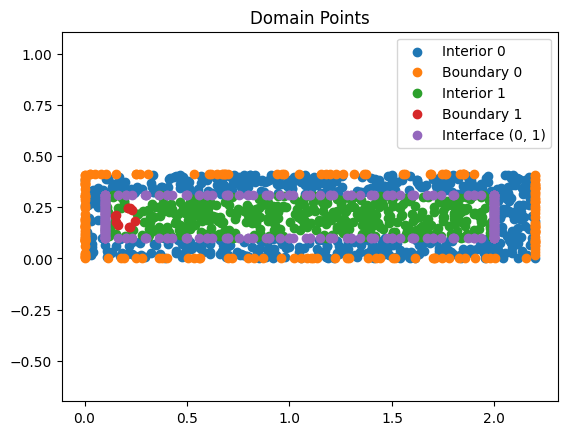

In [11]:
import matplotlib.pyplot as plt

plt.axis("equal")

domain.plot()

In [12]:
def sort_boundaries(domain_dict: dict, file: Path):
    """Sorts the boundary points in the json file and adds the 
        indices of the different boundaries to the dictionary.
        We have four different boundaries; left, wall, right and cylinder.

    Args:
        domain_dict (dict): Dictionary containing the data for the domain. Formated as domain.to_dict_format.
        file (Path): File-path for output file
    """
    
    data = domain_dict
        
    #create buckets for the different boundaries
    left_boundary = []
    wall_boundary = []
    right_boundary = []
    cylinder_boundary = []
    for p in data['XPINNs']:
        for point in p['Boundary points']:
            if np.isclose(point[0], 0):
                left_boundary.append(point)    
            elif np.isclose(point[0], 2.2):
                right_boundary.append(point)
            elif np.isclose(point[1], 0) or np.isclose(point[1], 0.41):
                wall_boundary.append(point)
            else:
                cylinder_boundary.append(point)
                
        #now we combine the buckets and note the indecies of the different boundaries
        all_boundaries = left_boundary + wall_boundary + right_boundary + cylinder_boundary
        left_boundary_index = len(left_boundary)
        wall_boundary_index = left_boundary_index + len(wall_boundary)
        right_boundary_index = wall_boundary_index + len(right_boundary)
        cylinder_boundary_index = right_boundary_index + len(cylinder_boundary)
        
        p['Boundary points'] = all_boundaries
        p['left boundary'] = left_boundary
        p['wall boundary'] = wall_boundary
        p['right boundary'] = right_boundary
        p['cylinder boundary'] = cylinder_boundary
        p['Boundary indices'] = [left_boundary_index, wall_boundary_index, right_boundary_index, cylinder_boundary_index]
    
    with open(file, "w") as outfile:
        json.dump(data, outfile)

In [13]:
domain_dict = domain.to_dict_format()


file = data_path / f"NavierStokes/laimar_decomp_train_{n_boundary}_{n_interior}.json"

sort_boundaries(domain_dict, file)


In [ ]:
#domain.create_testing_data(1000, [0.0, 0.0], [2.2, 0.41])
#domain.write_to_file(data_path / "test_1000.json", False)

In [ ]:
#domain.plot(False)